# Posture detection keras model

## 1. Feature engineering

### 1. 1. Importing libraries and defining transformers  

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, make_union
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings("ignore")
import ipytest.magics
import pytest
# set the file name (required)
__file__ = 'drone_pos_model.ipynb'
######################################################################################
class Shuffler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        x=x.loc[np.random.permutation(x.index)]
        
        return x
############################################################################################
class XCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, x_columns):
        self.x_columns = x_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_x","leftShoulder_x","leftHip_x","rightHip_x"]].sum(axis=1)/4
        for col in self.x_columns:
            x[col] = x[col] - shift
        return x
############################################################################################
class YCentralizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, y_columns):
        self.y_columns = y_columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shift=x[["rightShoulder_y","leftShoulder_y","leftHip_y","rightHip_y"]].sum(axis=1)/4
        for col in list(set(self.y_columns)-set(["label"])):
            x[col] = x[col] - shift
        return x
############################################################################################
class YScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x): #x is df
        shoulder_y = x[["rightShoulder_y","leftShoulder_y"]].sum(axis=1)/2
        hip_y = x[["leftHip_y","rightHip_y"]].sum(axis=1)/2
        y_dist = hip_y - shoulder_y
        
        for col in list(set(x.columns)-set(["label"])):
            x[col] /= y_dist
        return x

### 1. 2.  Data inspecting

In [2]:
path = "video_all_posture_steptime50_checksum8160"
df = pd.read_csv("../data/"+ path + ".csv",low_memory=False)
df1=df.dropna().drop_duplicates()
print(df1.shape)
df1[:3]

(3719, 17)


,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,0.49250,0.18750,0.4000,0.18250,0.5050,0.26000,0.34375,0.19500,0.50875,0.33875,0.26625,0.16875,0.46500,0.34375,0.41125,0.34625,1
1,0.49250,0.18875,0.4025,0.18625,0.5075,0.25875,0.33250,0.19750,0.50000,0.33750,0.27625,0.17500,0.46750,0.33625,0.40875,0.33750,1
2,0.49125,0.19000,0.4025,0.17875,0.5050,0.26125,0.33500,0.19875,0.51125,0.33500,0.26375,0.16875,0.46375,0.33875,0.40875,0.33750,1


In [3]:
# Checking that we don't have any null values
assert df1.isnull().all().all() == False

### 1. 3. Setting the pipeline arguments

In [4]:
x_cols = ['leftShoulder_x', 'rightShoulder_x',
        'leftElbow_x', 'rightElbow_x',
        'leftWrist_x', 'rightWrist_x',
        'leftHip_x', 'rightHip_x']
y_cols = list(set(df1.columns)-set(x_cols))

### 1. 4. Data processor pipeline

In [5]:
processing_pipeline = make_pipeline(XCentralizer(x_cols), YCentralizer(y_cols), YScaler(), Shuffler())
processed_df = processing_pipeline.fit_transform(df1)
processed_df[:3]

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftElbow_x,leftElbow_y,rightElbow_x,rightElbow_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
1833,0.275000,-0.486364,-0.270455,-0.513636,0.411364,0.022727,-0.470455,-0.004545,0.511364,0.377273,-0.461364,0.331818,0.184091,0.477273,-0.188636,0.522727,0
2728,0.197368,-0.517544,-0.293860,-0.482456,0.346491,0.043860,-0.267544,0.008772,0.364035,0.587719,-0.127193,0.570175,0.232456,0.491228,-0.135965,0.508772,4
330,0.305085,-0.500000,-0.288136,-0.500000,0.398305,0.016949,-0.406780,0.050847,0.406780,0.483051,-0.432203,0.491525,0.169492,0.516949,-0.186441,0.483051,4


In [6]:
assert df1.shape[0] == processed_df.shape[0]

## 2. Model training

### 2. 1.  Train, test splitting

In [7]:
df_train = processed_df.iloc[:int(processed_df.shape[0]*0.8)]
df_test = processed_df.iloc[int(processed_df.shape[0]*0.8):]

In [8]:
assert df_train.shape[0] + df_test.shape[0] == df1.shape[0]

### 2. 2. Setting numpy arrays to be feeded in the neural networks 

In [9]:
x_train=df_train.drop(['label'], axis=1).values
y_train=df_train['label'].values
x_test=df_test.drop(['label'], axis=1).values
y_test=df_test['label'].values
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


In [10]:
print(x_train.shape, y_train.shape )
print("x_train[0]=", x_train[0],"\n y_train[0]=", y_train[0])

(2975, 16) (2975, 5)
x_train[0]= [ 0.275      -0.48636364 -0.27045455 -0.51363636  0.41136364  0.02272727
 -0.47045455 -0.00454545  0.51136364  0.37727273 -0.46136364  0.33181818
  0.18409091  0.47727273 -0.18863636  0.52272727] 
 y_train[0]= [1. 0. 0. 0. 0.]


### 2. 3. Model Architecture

In [11]:
from keras import models, layers
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers, losses, metrics

model = models.Sequential()
model.add(layers.Dense(
        20, 
        activation="relu", 
        input_shape=(16, )))
model.add(layers.Dense(15, activation="relu"))
model.add(layers.Dense(5, activation="softmax")) 
model.summary()   

model.compile(
optimizer=optimizers.RMSprop(lr=0.005),
loss=losses.categorical_crossentropy,
metrics=["accuracy"] 
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 80        
Total params: 735
Trainable params: 735
Non-trainable params: 0
_________________________________________________________________


### 2. 4. Model fitting and validation 

In [12]:
history = model.fit(x_train, y_train, epochs=2000, batch_size=30, validation_split=0.2)

Train on 2380 samples, validate on 595 samples
Epoch 1/2000
2380/2380 [==============================] - 0s 94us/step - loss: 1.3046 - acc: 0.5105 - val_loss: 1.1085 - val_acc: 0.5529
Epoch 2/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.9607 - acc: 0.6794 - val_loss: 0.8463 - val_acc: 0.6756
Epoch 3/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.7939 - acc: 0.7492 - val_loss: 0.8414 - val_acc: 0.6723
Epoch 4/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.7134 - acc: 0.7739 - val_loss: 0.7087 - val_acc: 0.7866
Epoch 5/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.6568 - acc: 0.8038 - val_loss: 0.6066 - val_acc: 0.8151
Epoch 6/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.6149 - acc: 0.8189 - val_loss: 0.7823 - val_acc: 0.7059
Epoch 7/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.5784 - acc: 0.8303 - val_loss: 0.5519 - val_acc: 0

2380/2380 [==============================] - 0s 44us/step - loss: 0.2891 - acc: 0.9084 - val_loss: 0.3351 - val_acc: 0.8975
Epoch 61/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.2838 - acc: 0.9097 - val_loss: 0.3812 - val_acc: 0.8706
Epoch 62/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.2862 - acc: 0.9113 - val_loss: 0.5111 - val_acc: 0.8202
Epoch 63/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.2956 - acc: 0.9050 - val_loss: 0.3137 - val_acc: 0.8992
Epoch 64/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.2885 - acc: 0.9084 - val_loss: 0.3279 - val_acc: 0.9025
Epoch 65/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.2799 - acc: 0.9063 - val_loss: 0.3299 - val_acc: 0.9008
Epoch 66/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.2786 - acc: 0.9109 - val_loss: 0.3114 - val_acc: 0.9076
Epoch 67/2000
2380/2380 [=======================

2380/2380 [==============================] - 0s 45us/step - loss: 0.1957 - acc: 0.9345 - val_loss: 0.3642 - val_acc: 0.9076
Epoch 179/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.1912 - acc: 0.9315 - val_loss: 0.3531 - val_acc: 0.9092
Epoch 180/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.1930 - acc: 0.9332 - val_loss: 0.3410 - val_acc: 0.9176
Epoch 181/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1926 - acc: 0.9328 - val_loss: 0.3690 - val_acc: 0.9042
Epoch 182/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1926 - acc: 0.9336 - val_loss: 0.6799 - val_acc: 0.8336
Epoch 183/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1899 - acc: 0.9366 - val_loss: 0.3932 - val_acc: 0.9109
Epoch 184/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.2035 - acc: 0.9315 - val_loss: 0.3462 - val_acc: 0.9076
Epoch 185/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.1676 - acc: 0.9458 - val_loss: 0.3773 - val_acc: 0.9193
Epoch 238/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1780 - acc: 0.9366 - val_loss: 0.3701 - val_acc: 0.9092
Epoch 239/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1781 - acc: 0.9357 - val_loss: 0.3515 - val_acc: 0.9277
Epoch 240/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1759 - acc: 0.9387 - val_loss: 0.4532 - val_acc: 0.8958
Epoch 241/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1800 - acc: 0.9403 - val_loss: 0.3853 - val_acc: 0.9210
Epoch 242/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1781 - acc: 0.9370 - val_loss: 0.4413 - val_acc: 0.9109
Epoch 243/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1776 - acc: 0.9374 - val_loss: 0.4203 - val_acc: 0.9092
Epoch 244/2000
2380/2380 [================

2380/2380 [==============================] - 0s 44us/step - loss: 0.1733 - acc: 0.9412 - val_loss: 0.3707 - val_acc: 0.9244
Epoch 297/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1654 - acc: 0.9433 - val_loss: 0.3507 - val_acc: 0.9143
Epoch 298/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1594 - acc: 0.9441 - val_loss: 0.3912 - val_acc: 0.9008
Epoch 299/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1632 - acc: 0.9420 - val_loss: 0.3750 - val_acc: 0.9193
Epoch 300/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1596 - acc: 0.9437 - val_loss: 0.4429 - val_acc: 0.8958
Epoch 301/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1671 - acc: 0.9462 - val_loss: 0.3828 - val_acc: 0.9059
Epoch 302/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1664 - acc: 0.9441 - val_loss: 0.4100 - val_acc: 0.9193
Epoch 303/2000
2380/2380 [================

2380/2380 [==============================] - 0s 44us/step - loss: 0.1530 - acc: 0.9450 - val_loss: 0.3721 - val_acc: 0.9277
Epoch 356/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1476 - acc: 0.9462 - val_loss: 0.3453 - val_acc: 0.9311
Epoch 357/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1521 - acc: 0.9483 - val_loss: 0.4793 - val_acc: 0.8992
Epoch 358/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1496 - acc: 0.9508 - val_loss: 0.4772 - val_acc: 0.8924
Epoch 359/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1550 - acc: 0.9466 - val_loss: 0.3708 - val_acc: 0.9193
Epoch 360/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1606 - acc: 0.9450 - val_loss: 0.3962 - val_acc: 0.9092
Epoch 361/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1459 - acc: 0.9483 - val_loss: 0.4254 - val_acc: 0.9025
Epoch 362/2000
2380/2380 [================

2380/2380 [==============================] - 0s 42us/step - loss: 0.1469 - acc: 0.9487 - val_loss: 0.4429 - val_acc: 0.9143
Epoch 415/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1471 - acc: 0.9462 - val_loss: 0.3536 - val_acc: 0.9244
Epoch 416/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1407 - acc: 0.9454 - val_loss: 0.4289 - val_acc: 0.9176
Epoch 417/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1470 - acc: 0.9458 - val_loss: 0.4749 - val_acc: 0.8924
Epoch 418/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1378 - acc: 0.9475 - val_loss: 0.4580 - val_acc: 0.8975
Epoch 419/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1467 - acc: 0.9454 - val_loss: 0.3736 - val_acc: 0.9143
Epoch 420/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1426 - acc: 0.9513 - val_loss: 0.3953 - val_acc: 0.9227
Epoch 421/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.1369 - acc: 0.9517 - val_loss: 0.4631 - val_acc: 0.9076
Epoch 474/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1414 - acc: 0.9534 - val_loss: 0.4706 - val_acc: 0.9109
Epoch 475/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1326 - acc: 0.9513 - val_loss: 0.4056 - val_acc: 0.9143
Epoch 476/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1314 - acc: 0.9517 - val_loss: 0.4602 - val_acc: 0.9076
Epoch 477/2000
2380/2380 [==============================] - 0s 40us/step - loss: 0.1283 - acc: 0.9492 - val_loss: 0.3797 - val_acc: 0.9277
Epoch 478/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1284 - acc: 0.9534 - val_loss: 0.4115 - val_acc: 0.9126
Epoch 479/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1372 - acc: 0.9559 - val_loss: 0.4104 - val_acc: 0.9160
Epoch 480/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.1319 - acc: 0.9521 - val_loss: 0.4464 - val_acc: 0.9126
Epoch 533/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1134 - acc: 0.9538 - val_loss: 0.5144 - val_acc: 0.9076
Epoch 534/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1276 - acc: 0.9546 - val_loss: 0.4512 - val_acc: 0.9176
Epoch 535/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1263 - acc: 0.9597 - val_loss: 1.4744 - val_acc: 0.7950
Epoch 536/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1333 - acc: 0.9567 - val_loss: 0.5551 - val_acc: 0.8908
Epoch 537/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1172 - acc: 0.9576 - val_loss: 0.4421 - val_acc: 0.9210
Epoch 538/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1205 - acc: 0.9563 - val_loss: 0.4652 - val_acc: 0.9109
Epoch 539/2000
2380/2380 [================

2380/2380 [==============================] - 0s 41us/step - loss: 0.1269 - acc: 0.9529 - val_loss: 0.4505 - val_acc: 0.9143
Epoch 592/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1201 - acc: 0.9605 - val_loss: 0.5382 - val_acc: 0.8992
Epoch 593/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1172 - acc: 0.9563 - val_loss: 0.5564 - val_acc: 0.9025
Epoch 594/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1199 - acc: 0.9584 - val_loss: 0.6700 - val_acc: 0.8807
Epoch 595/2000
2380/2380 [==============================] - 0s 40us/step - loss: 0.1142 - acc: 0.9613 - val_loss: 0.4486 - val_acc: 0.9143
Epoch 596/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1226 - acc: 0.9546 - val_loss: 0.5181 - val_acc: 0.8958
Epoch 597/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1169 - acc: 0.9576 - val_loss: 0.5090 - val_acc: 0.9126
Epoch 598/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.1155 - acc: 0.9567 - val_loss: 0.4453 - val_acc: 0.9143
Epoch 651/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1063 - acc: 0.9634 - val_loss: 0.4842 - val_acc: 0.9210
Epoch 652/2000
2380/2380 [==============================] - 0s 40us/step - loss: 0.1112 - acc: 0.9580 - val_loss: 0.4755 - val_acc: 0.9176
Epoch 653/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1090 - acc: 0.9626 - val_loss: 0.4957 - val_acc: 0.9025
Epoch 654/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1211 - acc: 0.9538 - val_loss: 0.5517 - val_acc: 0.9143
Epoch 655/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1209 - acc: 0.9567 - val_loss: 0.4820 - val_acc: 0.9193
Epoch 656/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1118 - acc: 0.9580 - val_loss: 0.4722 - val_acc: 0.9176
Epoch 657/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.1150 - acc: 0.9609 - val_loss: 0.5282 - val_acc: 0.9126
Epoch 710/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1101 - acc: 0.9639 - val_loss: 0.5315 - val_acc: 0.9143
Epoch 711/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1307 - acc: 0.9550 - val_loss: 0.4889 - val_acc: 0.9210
Epoch 712/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1236 - acc: 0.9546 - val_loss: 0.4600 - val_acc: 0.9277
Epoch 713/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1221 - acc: 0.9546 - val_loss: 0.4938 - val_acc: 0.9160
Epoch 714/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1158 - acc: 0.9609 - val_loss: 0.5254 - val_acc: 0.9210
Epoch 715/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1080 - acc: 0.9601 - val_loss: 0.4591 - val_acc: 0.9294
Epoch 716/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.1177 - acc: 0.9588 - val_loss: 0.5369 - val_acc: 0.9176
Epoch 769/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1083 - acc: 0.9630 - val_loss: 0.5329 - val_acc: 0.9126
Epoch 770/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1109 - acc: 0.9588 - val_loss: 0.5352 - val_acc: 0.9244
Epoch 771/2000
2380/2380 [==============================] - 0s 40us/step - loss: 0.1133 - acc: 0.9592 - val_loss: 0.5489 - val_acc: 0.9143
Epoch 772/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1041 - acc: 0.9613 - val_loss: 0.6005 - val_acc: 0.9042
Epoch 773/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1109 - acc: 0.9601 - val_loss: 0.5185 - val_acc: 0.9143
Epoch 774/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1253 - acc: 0.9601 - val_loss: 0.5078 - val_acc: 0.9244
Epoch 775/2000
2380/2380 [================

2380/2380 [==============================] - 0s 41us/step - loss: 0.1059 - acc: 0.9584 - val_loss: 0.5736 - val_acc: 0.9126
Epoch 828/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1201 - acc: 0.9584 - val_loss: 0.5014 - val_acc: 0.9227
Epoch 829/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1038 - acc: 0.9601 - val_loss: 0.5277 - val_acc: 0.9143
Epoch 830/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.1066 - acc: 0.9571 - val_loss: 0.5752 - val_acc: 0.9008
Epoch 831/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1037 - acc: 0.9609 - val_loss: 0.5365 - val_acc: 0.9227
Epoch 832/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1054 - acc: 0.9622 - val_loss: 0.5361 - val_acc: 0.9193
Epoch 833/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1128 - acc: 0.9580 - val_loss: 0.5008 - val_acc: 0.9210
Epoch 834/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.0964 - acc: 0.9622 - val_loss: 0.5706 - val_acc: 0.9193
Epoch 887/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1006 - acc: 0.9647 - val_loss: 0.6455 - val_acc: 0.8992
Epoch 888/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1198 - acc: 0.9605 - val_loss: 0.5353 - val_acc: 0.9227
Epoch 889/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1156 - acc: 0.9597 - val_loss: 0.5194 - val_acc: 0.9210
Epoch 890/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1052 - acc: 0.9613 - val_loss: 0.5374 - val_acc: 0.9176
Epoch 891/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1086 - acc: 0.9576 - val_loss: 0.4989 - val_acc: 0.9126
Epoch 892/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1069 - acc: 0.9651 - val_loss: 0.5651 - val_acc: 0.9126
Epoch 893/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.1090 - acc: 0.9597 - val_loss: 0.5195 - val_acc: 0.9311
Epoch 946/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1255 - acc: 0.9550 - val_loss: 0.7516 - val_acc: 0.8840
Epoch 947/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.1228 - acc: 0.9584 - val_loss: 0.5418 - val_acc: 0.9227
Epoch 948/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1077 - acc: 0.9584 - val_loss: 0.6029 - val_acc: 0.8992
Epoch 949/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1132 - acc: 0.9576 - val_loss: 0.6176 - val_acc: 0.8992
Epoch 950/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1055 - acc: 0.9647 - val_loss: 0.5398 - val_acc: 0.9210
Epoch 951/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1081 - acc: 0.9555 - val_loss: 0.5490 - val_acc: 0.9244
Epoch 952/2000
2380/2380 [================

2380/2380 [==============================] - 0s 43us/step - loss: 0.0992 - acc: 0.9626 - val_loss: 0.5823 - val_acc: 0.9210
Epoch 1005/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1129 - acc: 0.9613 - val_loss: 0.5809 - val_acc: 0.9210
Epoch 1006/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1090 - acc: 0.9664 - val_loss: 0.5991 - val_acc: 0.9210
Epoch 1007/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1105 - acc: 0.9609 - val_loss: 0.5777 - val_acc: 0.9126
Epoch 1008/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1116 - acc: 0.9622 - val_loss: 0.5399 - val_acc: 0.9126
Epoch 1009/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0959 - acc: 0.9676 - val_loss: 0.5882 - val_acc: 0.9143
Epoch 1010/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1031 - acc: 0.9668 - val_loss: 0.5455 - val_acc: 0.9277
Epoch 1011/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 44us/step - loss: 0.1036 - acc: 0.9609 - val_loss: 0.6099 - val_acc: 0.9210
Epoch 1121/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1040 - acc: 0.9681 - val_loss: 0.6116 - val_acc: 0.9143
Epoch 1122/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1021 - acc: 0.9664 - val_loss: 0.5914 - val_acc: 0.9160
Epoch 1123/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1024 - acc: 0.9660 - val_loss: 0.6901 - val_acc: 0.8924
Epoch 1124/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.1123 - acc: 0.9622 - val_loss: 0.5438 - val_acc: 0.9193
Epoch 1125/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1016 - acc: 0.9639 - val_loss: 0.5713 - val_acc: 0.9126
Epoch 1126/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.0995 - acc: 0.9651 - val_loss: 0.6037 - val_acc: 0.9126
Epoch 1127/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 41us/step - loss: 0.1111 - acc: 0.9639 - val_loss: 0.6149 - val_acc: 0.9143
Epoch 1237/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1017 - acc: 0.9672 - val_loss: 0.6632 - val_acc: 0.8958
Epoch 1238/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1026 - acc: 0.9634 - val_loss: 0.6008 - val_acc: 0.9160
Epoch 1239/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1063 - acc: 0.9676 - val_loss: 0.7274 - val_acc: 0.8874
Epoch 1240/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1018 - acc: 0.9660 - val_loss: 0.6546 - val_acc: 0.9126
Epoch 1241/2000
2380/2380 [==============================] - 0s 40us/step - loss: 0.0969 - acc: 0.9664 - val_loss: 0.6353 - val_acc: 0.9092
Epoch 1242/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.0909 - acc: 0.9660 - val_loss: 0.6598 - val_acc: 0.9126
Epoch 1243/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 43us/step - loss: 0.0993 - acc: 0.9676 - val_loss: 0.6684 - val_acc: 0.9025
Epoch 1353/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.1002 - acc: 0.9651 - val_loss: 0.7273 - val_acc: 0.9076
Epoch 1354/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0890 - acc: 0.9756 - val_loss: 0.6058 - val_acc: 0.9076
Epoch 1355/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1100 - acc: 0.9672 - val_loss: 0.7330 - val_acc: 0.8941
Epoch 1356/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0917 - acc: 0.9685 - val_loss: 0.6913 - val_acc: 0.9008
Epoch 1357/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1137 - acc: 0.9622 - val_loss: 0.5891 - val_acc: 0.9042
Epoch 1358/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0880 - acc: 0.9702 - val_loss: 0.5928 - val_acc: 0.9025
Epoch 1359/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 42us/step - loss: 0.0969 - acc: 0.9664 - val_loss: 0.6768 - val_acc: 0.8958
Epoch 1469/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.0837 - acc: 0.9702 - val_loss: 0.7274 - val_acc: 0.8975
Epoch 1470/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.0918 - acc: 0.9689 - val_loss: 0.7978 - val_acc: 0.9008
Epoch 1471/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.0901 - acc: 0.9697 - val_loss: 0.7422 - val_acc: 0.8908
Epoch 1472/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0890 - acc: 0.9710 - val_loss: 0.6730 - val_acc: 0.8975
Epoch 1473/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.0949 - acc: 0.9702 - val_loss: 0.6740 - val_acc: 0.9092
Epoch 1474/2000
2380/2380 [==============================] - 0s 41us/step - loss: 0.0847 - acc: 0.9714 - val_loss: 0.6491 - val_acc: 0.9059
Epoch 1475/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 44us/step - loss: 0.1071 - acc: 0.9668 - val_loss: 0.6357 - val_acc: 0.9076
Epoch 1585/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0956 - acc: 0.9706 - val_loss: 0.7758 - val_acc: 0.8975
Epoch 1586/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.0945 - acc: 0.9702 - val_loss: 0.6617 - val_acc: 0.9092
Epoch 1587/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1063 - acc: 0.9685 - val_loss: 0.7096 - val_acc: 0.9059
Epoch 1588/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.0888 - acc: 0.9685 - val_loss: 0.8721 - val_acc: 0.8874
Epoch 1589/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1040 - acc: 0.9672 - val_loss: 0.7508 - val_acc: 0.8958
Epoch 1590/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1088 - acc: 0.9668 - val_loss: 0.6315 - val_acc: 0.9092
Epoch 1591/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 43us/step - loss: 0.0816 - acc: 0.9739 - val_loss: 0.7015 - val_acc: 0.9008
Epoch 1701/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.1011 - acc: 0.9702 - val_loss: 0.6619 - val_acc: 0.9025
Epoch 1702/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0993 - acc: 0.9689 - val_loss: 0.6560 - val_acc: 0.9160
Epoch 1703/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0984 - acc: 0.9681 - val_loss: 0.7601 - val_acc: 0.9025
Epoch 1704/2000
2380/2380 [==============================] - 0s 49us/step - loss: 0.0929 - acc: 0.9655 - val_loss: 0.7800 - val_acc: 0.9008
Epoch 1705/2000
2380/2380 [==============================] - 0s 48us/step - loss: 0.0922 - acc: 0.9668 - val_loss: 0.7028 - val_acc: 0.8975
Epoch 1706/2000
2380/2380 [==============================] - 0s 54us/step - loss: 0.0858 - acc: 0.9693 - val_loss: 0.7159 - val_acc: 0.8992
Epoch 1707/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 44us/step - loss: 0.0856 - acc: 0.9697 - val_loss: 0.6779 - val_acc: 0.9059
Epoch 1817/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0755 - acc: 0.9744 - val_loss: 0.7037 - val_acc: 0.9109
Epoch 1818/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.1021 - acc: 0.9685 - val_loss: 0.7192 - val_acc: 0.8941
Epoch 1819/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0874 - acc: 0.9723 - val_loss: 0.6104 - val_acc: 0.9109
Epoch 1820/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.0839 - acc: 0.9714 - val_loss: 0.6671 - val_acc: 0.9059
Epoch 1821/2000
2380/2380 [==============================] - 0s 45us/step - loss: 0.0897 - acc: 0.9756 - val_loss: 0.6572 - val_acc: 0.9210
Epoch 1822/2000
2380/2380 [==============================] - 0s 46us/step - loss: 0.0805 - acc: 0.9710 - val_loss: 0.6664 - val_acc: 0.9126
Epoch 1823/2000
2380/2380 [=========

2380/2380 [==============================] - 0s 45us/step - loss: 0.0995 - acc: 0.9676 - val_loss: 0.7353 - val_acc: 0.9042
Epoch 1933/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.0869 - acc: 0.9727 - val_loss: 0.6224 - val_acc: 0.9126
Epoch 1934/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.0822 - acc: 0.9710 - val_loss: 0.9675 - val_acc: 0.8891
Epoch 1935/2000
2380/2380 [==============================] - 0s 42us/step - loss: 0.1028 - acc: 0.9714 - val_loss: 0.7133 - val_acc: 0.9059
Epoch 1936/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.0908 - acc: 0.9697 - val_loss: 0.7228 - val_acc: 0.9042
Epoch 1937/2000
2380/2380 [==============================] - 0s 44us/step - loss: 0.0921 - acc: 0.9727 - val_loss: 0.7975 - val_acc: 0.8807
Epoch 1938/2000
2380/2380 [==============================] - 0s 43us/step - loss: 0.0906 - acc: 0.9689 - val_loss: 0.6770 - val_acc: 0.9008
Epoch 1939/2000
2380/2380 [=========

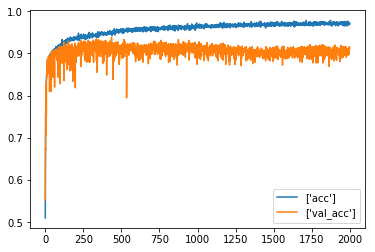

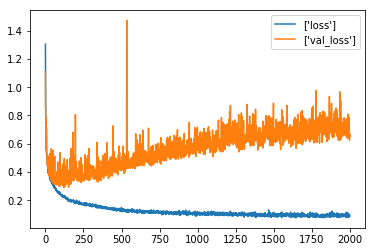

In [13]:
plt.plot(history.history["acc"],  label=["acc"])
plt.plot(history.history['val_acc'], label=["val_acc"])
plt.legend()
plt.show()
plt.close()

plt.plot(history.history["loss"], label=["loss"]) 
plt.plot(history.history['val_loss'], label=["val_loss"])
plt.legend()
plt.show()
plt.close()





###  2. 5. Model prediction

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss / Accuracy Evaluation")
print("--------------------------")
print("Loss:     " + str(round(test_loss,5)))
print("Accuracy: " + str(round(test_acc,5)))

744/744 [==============================] - 0s 19us/step
Loss / Accuracy Evaluation
--------------------------
Loss:     0.60622
Accuracy: 0.92876


In [15]:
y_tes_pred = model.predict(x_test)

In [16]:
y_tes_pred[10]

array([1.01508865e-30, 2.31634818e-15, 0.00000000e+00, 5.73616830e-07,
       9.99999404e-01], dtype=float32)

In [17]:
y_test[10]

array([0., 0., 0., 0., 1.], dtype=float32)

### 2. 6. Saving model in tensorflow.js Format

The tensorflowjs library can't be installed directly with pip / conda due to conflicting dependencies. Best is to set up a new environment explicitly for this and install tensorflowjs with the following commands:

```
pip install tensorflow==1.11.0rc2 h5py numpy keras
pip install --no-deps tensorflowjs
```

In [25]:
! pip install tensorflow==1.11.0rc2 h5py numpy keras
! pip install --no-deps tensorflowjs

  Could not find a version that satisfies the requirement tensorflow==1.11.0rc2 (from versions: 0.12.1, 1.0.0, 1.1.0rc0, 1.1.0rc1, 1.1.0rc2, 1.1.0, 1.2.0rc0, 1.2.0rc1, 1.2.0rc2, 1.2.0, 1.2.1, 1.3.0rc0, 1.3.0rc1, 1.3.0rc2, 1.3.0, 1.4.0rc0, 1.4.0rc1, 1.4.0, 1.4.1, 1.5.0rc0, 1.5.0rc1, 1.5.0, 1.5.1, 1.6.0rc0, 1.6.0rc1, 1.6.0, 1.7.0rc0, 1.7.0rc1, 1.7.0, 1.7.1, 1.8.0rc0, 1.8.0rc1, 1.8.0, 1.9.0rc0, 1.9.0rc1, 1.9.0rc2, 1.9.0, 1.10.0rc0, 1.10.0rc1, 1.10.0, 1.10.1, 1.11.0rc0, 1.11.0, 1.12.0rc0, 1.12.0rc1, 1.12.0rc2)
No matching distribution found for tensorflow==1.11.0rc2


In [26]:

! pip install --upgrade pip

Requirement already up-to-date: pip in /Users/lsafari/anaconda3/lib/python3.6/site-packages (18.1)


In [27]:
! pip install ipykernel
! pip install tensorflow_hub

In [21]:
import tensorflowjs as tfjs
from keras.models import load_model
import h5py

In [29]:
model.save('drone_pos_model-nonpipeline.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('drone_pos_model-nonpipeline.h5')

In [30]:
type(model)

keras.engine.sequential.Sequential

In [33]:
tfjs.converters.save_keras_model(model, 'model_json')

We need to adapt the two files as follows in order for them to work on Azure:
* add a file extension .pb to the file with no extension (otherwise Azure blocks it from viewing)
* adapt the automatically generated model.json to reflect the extension .pb